In [37]:
import random as rd
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import deque


def decide_to(p):
    # Return True with probability p, False with probability 1-p
    r = rd.uniform(0, 1)
    return r <= p

# Mutation function
def mutate(ind, N):
    '''
    Perform mutation by swapping two randomly chosen chromosomes.
    ind: array of N chromosomes
    '''
    i = rd.randrange(0, N)
    j = rd.randrange(0, N)
    ind[i], ind[j] = ind[j], ind[i]

# Crossover function
def crossover(father, mother, child1, child2, N):
    '''
    father and mother are two arrays of chromosomes with N elements each.
    child1 and child2 are two arrays of chromosomes with N elements each.
    '''
    # Randomly select the crossover range
    i = rd.randrange(0, N)
    j = rd.randrange(0, N)
    if i > j:
        i, j = j, i

    check1 = np.zeros(N)
    check2 = np.zeros(N)

    for x in range(i, j + 1):
        child1[x] = father[x]  # Child 1 inherits the chromosome range [i, j] from the father
        child2[x] = mother[x]  # Child 2 inherits the chromosome range [i, j] from the mother
        check1[father[x]] = 1
        check2[mother[x]] = 1

    # Copy the remaining chromosomes sequentially for child 1
    # Child 1 inherits the chromosome range [0, i-1] and [j+1, N-1] from the mother
    x = 0
    index = 0 + ((i == 0) * (j + 1))
    while x < N and index < N:
        if not check1[mother[x]]:
            child1[index] = mother[x]
            index += 1
        if index == i:
            index = j + 1
        x += 1

    # Copy the remaining chromosomes sequentially for child 2
    # Child 2 inherits the chromosome range [0, i-1] and [j+1, N-1] from the father
    x = 0
    index = 0 + ((i == 0) * (j + 1))
    while x < N and index < N:
        if not check2[father[x]]:
            child2[index] = father[x]
            index += 1
        if index == i:
            index = j + 1
        x += 1

# Function to calculate Euclidean distance for one cycle
def distance(points, order, N):
    '''
    points is a 2D array Nx2 storing the coordinates of points
    order is an array of N points in order
    Returns: Euclidean distance of the cycle
       '''
    x0 = points[0][0]
    y0 = points[0][1]
    xi = points[order[0]][0]
    yi = points[order[0]][1]
    s = round(math.sqrt((x0 - xi) ** 2 + (y0 - yi) ** 2))  # Euclidean distance

    for i in range(1, N):
        x1 = points[order[i - 1]][0]
        y1 = points[order[i - 1]][1]
        x2 = points[order[i]][0]
        y2 = points[order[i]][1]
        s += round(math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2))
    xn = points[order[N - 1]][0]
    yn = points[order[N - 1]][1]
    s += round(math.sqrt((x0 - xn) ** 2 + (y0 - yn) ** 2))
    return float(s)

# Function to initialize a population with K individuals, each having N chromosomes
def init_population(K, N):
    # Returns a 2D array of size K x N
    pop = np.zeros((K, N), dtype=np.int32)
    # Shuffle the chromosomes
    seq = list(range(N))
    for i in range(K):
        rd.shuffle(seq)
        pop[i] = seq
    return pop

# Fitness function
def compute_population_fitness(pop, points, K, N):
    '''
    The fitness of each individual is the negative value of its cycle distance.
    Returns an array fit with fit[k] = fitness of pop[k].

    '''
    fit = np.zeros(K)
    for k in range(K):
        fit[k] = -distance(points, pop[k], N)
    return fit

# Cumulative distribution function
def find_cumulative_distribution(arr, K):
    '''
    For arr, an array of K numbers, returns:
        An array cd with K elements, where cd[k] is the probability for a number in the range [0, arr.sum()]
        to be less than or equal to arr[:k].sum()
    '''
    cd = np.zeros(K)
    acc = 0
    s = arr.sum()
    for i in range(K):
        acc += arr[i] / s
        cd[i] = acc
    return cd

# Parent selection function using roulette wheel technique
def select_parent(fit, K):
    '''
    Returns the index of a parent.
    '''
    local_absolute_fitness = fit - fit.min()  # Min fitness = 0
    # Choose a random representative parent using the cumulative probability of each element.
    cd = find_cumulative_distribution(local_absolute_fitness, K)
    roulette = rd.uniform(0, 1)
    ind = 0
    while roulette > cd[ind]:
        ind += 1
    return ind

# Create a new population of K individuals with N chromosomes using crossover and mutation on the current population
def create_new_population(pop, fitness, K, N, crossover_probability, mutation_probability):
    '''
    crossover_probability is the crossover rate
    mutation_probability is the mutation rate
    Returns:
        A 2D array of size K x N
    '''
    new_pop = np.zeros((K, N), dtype=np.int32)
    for k in range(K // 2):  # Each iteration creates 2 children
        # Select parents
        father_ind = select_parent(fitness, K)
        mother_ind = select_parent(fitness, K)
        father = pop[father_ind]
        mother = pop[mother_ind]

        # Initialize two children from father and mother
        child1 = father.copy()
        child2 = mother.copy()

        # If there is a crossover probability, perform crossover between father, mother, and the two children
        # If there is a mutation probability, perform mutation on the currently examined child chromosome
        if decide_to(crossover_probability):
            crossover(father, mother, child1, child2, N)
        if decide_to(mutation_probability):
            mutate(child1, N)
        if decide_to(mutation_probability):
            mutate(child2, N)

        new_pop[k * 2] = child1
        new_pop[k * 2 + 1] = child2
    return new_pop

# Find the individual (chromosome) with the highest fitness over all generations
def find_best_individual(pop, fitness, best_individual, best_fit):
    '''
    Returns the best individual and the index of its highest fitness.
    '''
    current_best_index = fitness.argmax()
    current_best_fit = fitness[current_best_index]
    current_best_individual = pop[current_best_index]

    if best_fit < current_best_fit:
        return current_best_individual, current_best_fit
    else:
        return best_individual, best_fit

# Input function
def read_input(path, N):
    points = np.zeros((N, 2))
    file = open(path)
    lines = file.readlines()
    lines = [x.replace(',', ' ') for x in lines]
    file.close()
    for i in range(N):
        points[i][0], points[i][1] = map(int, lines[i].split())
    return points

# Plot the individual path
def plot_individual_path(individual, points, title, index):
    x = []
    y = []
    for i in individual:
        x.append(points[i][0])
        y.append(points[i][1])
    x.append(x[0])
    y.append(y[0])

    plt.subplot(3, 5, index)
    plt.title(title)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.plot(x, y, 'r*')
    plt.plot(x, y, 'g--')

# Plot the results of the best 15 individuals over generations
def plot_results(best_last_15, points):
    '''
    best_last_15 is a deque with 2D arrays.
    '''
    for i in range(0, len(best_last_15)):
        plot_individual_path(best_last_15[i][0], points, str(round(best_last_15[i][1], 2)), i + 1)
    plt.show()


def TSP_genetic(n, k, max_generation, crossover_probability, mutation_probability, path):
    '''
    Solve the TSP problem using GA with chromosomes decoded as cycles (solutions).
    n: integer representing the number of points, also the number of genes in each individual
    k: integer representing the number of individuals (population size) in each generation
    max_generation: integer representing the maximum number of generations (iterations of the algorithm)
    crossover_probability: float in the range [0, 1] representing the crossover rate
    mutation_probability: float in the range [0, 1] representing the mutation rate
    path: path to the text file
    '''
    points = read_input(path, n)
    population = init_population(k, n)
    best_individual = population[0]  # Choose the first individual as the best individual
    best_fitness = -distance(points, best_individual, n)
    old_best_fitness = best_fitness
    best_last_15 = deque([], maxlen=15)
    len_path = []

    for generation in range(1, max_generation + 1):
        # 1. Compute fitness of each individual in the population
        fitness = compute_population_fitness(population, points, k, n)
        # 2. Find the individual with the highest fitness
        best_individual, best_fitness = find_best_individual(population, fitness, best_individual, best_fitness)
        # 3. Save the last 15 individuals
        if old_best_fitness != best_fitness:
            old_best_fitness = best_fitness
            best_last_15.append((best_individual.copy(), -best_fitness))
        # 4. Create a new generation
        population = create_new_population(population, fitness, k, n, crossover_probability, mutation_probability)
        # 5. Print the current best fitness
        print("Generation =", generation, '\t', "Path length =", -best_fitness)
        len_path.append(-best_fitness)

    solution = best_individual
    cycle_distance = -best_fitness

    print(cycle_distance)
    print(solution+1)

    plt.figure(figsize=(14, 14))
    plt.subplot(1, 2, 1)
    plt.plot(range(max_generation), len_path, label='Path length')
    plt.legend(loc='lower right')
    plt.title('Path length')
    plt.show()

            
    return solution + 1


In [52]:
from random import choices, randint, randrange, random
import random as rd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Input parameters for KP and TSP
# Knapsack Problem
parent_size = 2
mutation_prob = 0.5        # tuning parameter
generation_limit = 200
population_size = 50        # tuning parameter
init_prob = 0.5            # tuning parameter
fitness_limit = 0           # not used
top_sol = 2                # Top 2 solutions to be retained when moving to the next generation

data = [
   "a280-n279.txt",
]

# TSP
max_generation = 200
crossover_probability = 0.50
mutation_probability = 0.01

# Define Genetic Algorithm for the Knapsack Problem
def generate_genome(length: int, Inputs):
    # Create an array with random 0s and 1s
    # Keep the last half as 0s to converge faster
    prob = Inputs[3] / np.sum(Inputs[0])
    a = np.random.choice([0, 1], size=(int(length * Inputs[14]),), p=[1 - prob, prob])
    b = np.random.choice([0, 0], size=(length - int(length * Inputs[14]),), p=[0.5, 0.5])
    return np.append(a, b)

# Function to generate a population (array of genomes)
def generate_population(size: int, genome_length: int, Inputs):
    return [generate_genome(genome_length, Inputs) for i in range(size)]

# Fitness function
def fitness(genome, Inputs):
    w = 0   # Weight
    v = 0   # Velocity when moving to a city
    p = 0   # Profit
    t = 0   # Time when moving to a city

    # Profit of items at the current city
    loop_profit = np.zeros(len(Inputs[1]))

    for i in range(1, len(genome) + 1):
        # Add the weight of an item
        w += genome[i - 1] * Inputs[0][i - 1]
        if w <= Inputs[3]:

            # Velocity = (vmax - (vmax - vmin) * (current weight / weight limit))
            v = Inputs[4] - (Inputs[4] - Inputs[5]) * (w / Inputs[3])

            # Check when moving to a city
            if (i) % Inputs[7] == 0 and i < len(genome):

                # Calculate travel time = distance / velocity
                t = np.abs(Inputs[2][i - 1] - Inputs[2][i]) / v
                loop_profit[i: i + Inputs[7]] = (Inputs[1][i: i + Inputs[7]]) / (t * Inputs[2][i: i + Inputs[7]])

            # Add profit
            p += loop_profit[i - 1]
            p = p - (p / Inputs[13])
        if w > Inputs[3]:
            p = 1e-10
            break
    return p

# Select a pair for creating a new generation
def selection_pair(population):
    new_population = choices(
        population=population,
        weights=[fitness(genome, Inputs) for genome in population],
        k=Inputs[8]
    )
    return new_population

# Single-point crossover
def single_point_crossover(a, b):
    p = randint(1, len(a) - 1)
    if len(a) == len(b) and len(a) > 2:
        return a, b
    return a[0: p] + b[p:], b[0: p] + a[p:]

# Mutation
def mutation(genome, Inputs):
    index = randrange(len(genome))
    if random() > Inputs[9]:
        genome[index] = genome[index]
    else:
        genome[index] = abs(genome[index] - 1)
    return genome

# Run the genetic algorithm for Knapsack
def run_evolution(pop_size, genome_length, Inputs):
    prof = 0
    weg = 0
    pop = generate_population(pop_size, genome_length, Inputs)
    profits = []
    weights = []
    for i in range(Inputs[10]):
        pop = sorted(pop, key=lambda genome: fitness(genome, Inputs), reverse=True)
        prof = np.sum(new_profit * pop[0])
        weg = np.sum(new_weights * pop[0])
        next_gen = pop[0: Inputs[12]]

        for j in range(int(len(pop) / 2) - int(Inputs[12] / 2)):
            parents = selection_pair(pop)
            child_a, child_b = single_point_crossover(parents[0], parents[1])
            child_a = mutation(child_a, Inputs)
            child_b = mutation(child_b, Inputs)
            next_gen += [child_a, child_b]

        next_gen = sorted(next_gen, key=lambda genome: fitness(genome, Inputs), reverse=True)
        n_prof = np.sum(new_profit * next_gen[0])
        n_weg = np.sum(new_weights * next_gen[0])
        print("Generation = ", i, '\t', "Profit = ", n_prof, '\t', "Weight = ", n_weg)

        profits.append(n_prof)
        weights.append(n_weg)

        if n_weg > Inputs[3]:
            print('\n', "Knapsack capacity exceeded")
            print("Max profit = ", prof)
            print("Knapsack weight = ", weg)
            break
        else:
            pop = next_gen

    plt.figure(figsize=(14, 14))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(profits)), profits, label='Profits')
    plt.plot(range(len(weights)), weights, label='Weights')
    plt.legend(loc='lower right')
    plt.title('Profits and Weights')
    plt.show()
    print(max(profits))
    
    return pop[0]


a280-n279.txt
Generation = 1 	 Path length = 31667.0
Generation = 2 	 Path length = 31515.0
Generation = 3 	 Path length = 31515.0
Generation = 4 	 Path length = 31099.0
Generation = 5 	 Path length = 31099.0
Generation = 6 	 Path length = 31013.0
Generation = 7 	 Path length = 30625.0
Generation = 8 	 Path length = 30616.0
Generation = 9 	 Path length = 30616.0
Generation = 10 	 Path length = 30424.0
Generation = 11 	 Path length = 30424.0
Generation = 12 	 Path length = 30279.0
Generation = 13 	 Path length = 30079.0
Generation = 14 	 Path length = 29664.0
Generation = 15 	 Path length = 29664.0
Generation = 16 	 Path length = 29633.0
Generation = 17 	 Path length = 29480.0
Generation = 18 	 Path length = 29480.0
Generation = 19 	 Path length = 29475.0
Generation = 20 	 Path length = 29395.0
Generation = 21 	 Path length = 29288.0
Generation = 22 	 Path length = 29098.0
Generation = 23 	 Path length = 29098.0
Generation = 24 	 Path length = 28884.0
Generation = 25 	 Path length = 284

C:\Users\hadee\AppData\Local\Temp\ipykernel_16152\484520284.py:126: RuntimeWarning: invalid value encountered in scalar divide
  acc += arr[i] / s


Generation = 177 	 Path length = 22447.0
Generation = 178 	 Path length = 22367.0
Generation = 179 	 Path length = 22367.0
Generation = 180 	 Path length = 22367.0
Generation = 181 	 Path length = 22367.0
Generation = 182 	 Path length = 22367.0
Generation = 183 	 Path length = 22367.0
Generation = 184 	 Path length = 22367.0
Generation = 185 	 Path length = 22367.0
Generation = 186 	 Path length = 22286.0
Generation = 187 	 Path length = 22286.0
Generation = 188 	 Path length = 22286.0
Generation = 189 	 Path length = 22261.0
Generation = 190 	 Path length = 22261.0
Generation = 191 	 Path length = 22179.0
Generation = 192 	 Path length = 22179.0
Generation = 193 	 Path length = 22109.0
Generation = 194 	 Path length = 22109.0
Generation = 195 	 Path length = 22109.0
Generation = 196 	 Path length = 22109.0
Generation = 197 	 Path length = 22108.0
Generation = 198 	 Path length = 22108.0
Generation = 199 	 Path length = 22024.0
Generation = 200 	 Path length = 22024.0
22024.0
[273  32

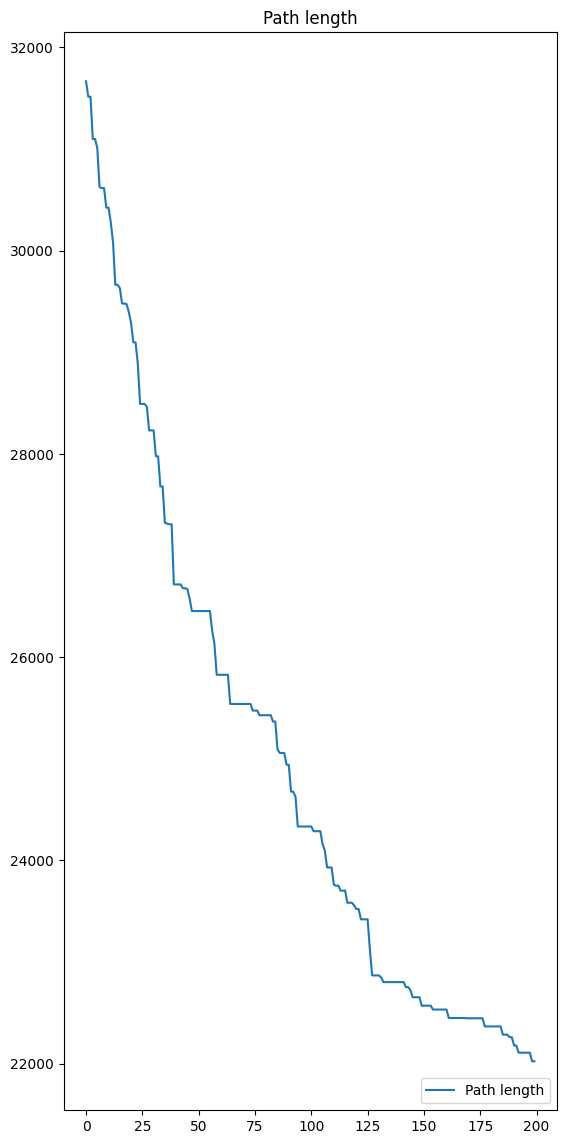

Generation =  0 	 Profit =  7093.0 	 Weight =  6193.0
Generation =  1 	 Profit =  7440.0 	 Weight =  6440.0
Generation =  2 	 Profit =  9320.0 	 Weight =  7920.0
Generation =  3 	 Profit =  9320.0 	 Weight =  7920.0
Generation =  4 	 Profit =  9791.0 	 Weight =  8291.0
Generation =  5 	 Profit =  16589.0 	 Weight =  13989.0
Generation =  6 	 Profit =  20653.0 	 Weight =  17253.0
Generation =  7 	 Profit =  24332.0 	 Weight =  20632.0
Generation =  8 	 Profit =  34109.0 	 Weight =  28709.0

 Knapsack capacity exceeded
Max profit =  24332.0
Knapsack weight =  20632.0


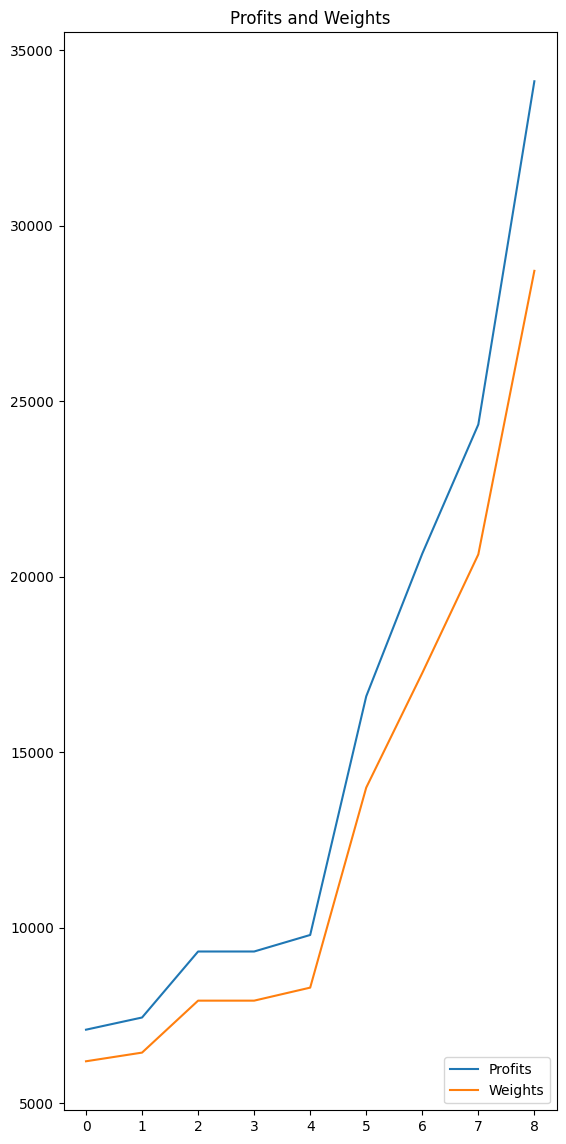

34109.0


In [53]:
# Read data files
for data_file in data:
    print(data_file)
    with open(data_file, "r") as f:
        lines = f.readlines()
        lines = lines[2:]
        lines = [x.strip() for x in lines]
        lines = [x.replace(':', '') for x in lines]
        lines = [x.replace('(', '') for x in lines]
        lines = [x.replace(')', '') for x in lines]
        lines = [x.split('\t') for x in lines]

        for i in range(len(lines)):
            # Read coordinates
            if lines[i][0] == "NODE_COORD_SECTION":
                start = i

            # Read the number of points (dimensions)
            if lines[i][0] == "DIMENSION":
                dimension = int(lines[i][1])

            # Read the number of items
            if lines[i][0] == "NUMBER OF ITEMS ":
                items = int(lines[i][1])

            # Read the knapsack capacity
            if lines[i][0] == "CAPACITY OF KNAPSACK ":
                weight_limit = int(lines[i][1])

            # Read the minimum speed
            if lines[i][0] == "MIN SPEED ":
                vmin = float(lines[i][1])

            # Read the maximum speed
            if lines[i][0] == "MAX SPEED ":
                vmax = float(lines[i][1])

            # Read the renting ratio
            if lines[i][0] == "RENTING RATIO ":
                rent_ratio = float(lines[i][1])

        # Assume all cities have the same number of items
        item_per_city = int(items / (dimension - 1))

        # Read coordinates
        loc = np.array(lines[start + 1: start + dimension + 1])
        loc[loc == ''] = 0
        loc = loc.astype(np.int32)

        # Sort locations by index
        loc = loc[np.argsort(loc[:, 0])]
        # Starting point
        start_loc = [loc[0, 1], loc[0, 2]]
        x_loc = loc[:, 1]
        y_loc = loc[:, 2]
        xy_loc = np.transpose(np.matrix([x_loc, y_loc]))  # Transpose the matrix

        # Write X, Y coordinates for TSP
        with open('nodes.txt', 'wb') as f:
            for line in xy_loc:
                np.savetxt(f, xy_loc, delimiter=',', fmt='%i')

        # Calculate the distance matrix between points
        dist_mat = np.zeros((dimension, dimension))

        for i in range(0, len(loc)):
            for j in range(0, len(loc)):
                dist_mat[i][j] = round(np.sqrt((loc[i][1] - loc[j][1]) ** 2 + (loc[i][2] - loc[j][2]) ** 2))

        # Create a DataFrame
        df_loc = pd.DataFrame(loc, columns=lines[start][1].split(','))
        # Sort by index
        # loc_sort = df_loc.sort_values(by=['INDEX'])

        # Read the list of items
        bag = np.array(lines[start + dimension + 2: start + dimension + items + 2])
        bag[bag == ''] = 0
        bag = bag.astype(np.int32)

        # Sort by the allocated city (last column)
        bag = bag[np.argsort(bag[:, -1])]

        # Define profit as the array of item values after sorting
        # Define weights as the array of item weights after sorting
        # Define nodes as the array of items after sorting
        profit = bag[:, 1]
        weights = bag[:, 2]
        node = bag[:, 3]

        # Combine locations and items
        loc_bag = np.insert(bag, [np.ma.size(bag, 1)], [0, 0], axis=1)

        # Create a DataFrame
        df_loc_bag = pd.DataFrame(
            loc_bag,
            columns=[lines[start + dimension + 1][1].split(',') + lines[start][1].split(',')[1:]])

        for i in range(len(df_loc_bag)):
            a = df_loc_bag.loc[i].at[' ASSIGNED NODE NUMBER'].item()
            df_loc_bag.loc[i].at[' X'] = loc[np.where(loc[:, 0] == a)[0][0], 1]
            df_loc_bag.loc[i].at[' Y'] = loc[np.where(loc[:, 0] == a)[0][0], 2]

    # Use Genetic Algorithm for TSP
    n = dimension - 1
    k = 100
    path = 'nodes.txt' # store node coordenates
    best_path = TSP_genetic(n, k, max_generation, crossover_probability, mutation_probability, path)
    # Best path from position 0
    best_path = np.insert(best_path, 0, 0)

    # Create profit and weights arrays from the best_path
    node_weights = np.zeros((len(best_path) - 1) * item_per_city)
    dist = 0
    new_profit = np.zeros(len(profit))
    new_weights = np.zeros(len(weights))

    for i in range(len(best_path) - 1):
        x1 = x_loc[best_path[i]]
        x2 = x_loc[best_path[i + 1]]
        y1 = y_loc[best_path[i]]
        y2 = y_loc[best_path[i + 1]]
        dist += round(np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2))
        start = i * item_per_city
        end = start + item_per_city
        node_weights[start: end] = dist
        new_profit[start: end] = profit[
                                  (best_path[i + 1] * item_per_city) - item_per_city: (best_path[i + 1] * item_per_city)]
        new_weights[start: end] = weights[
                                  (best_path[i + 1] * item_per_city) - item_per_city: (best_path[i + 1] * item_per_city)]

    # Solve the Knapsack problem using Genetic Algorithm
    Inputs = [new_weights, new_profit, node_weights, weight_limit,
              vmax, vmin, best_path, item_per_city, parent_size,
              mutation_prob, generation_limit, fitness_limit, top_sol,
              rent_ratio, init_prob]

    if weight_limit < np.sum(new_weights):
        pop = run_evolution(population_size, items, Inputs)
        total_prof = np.sum(new_profit * pop)
    else:
        pop = np.ones(len(population_size))
        

In [49]:
def write_solution_files(team_name, problem_name, tour, packing_plan, time, profit):
    tour_file = f"{team_name}_{problem_name}.x"
    values_file = f"{team_name}_{problem_name}.f"

    # Writing the tour and packing plan
    with open(tour_file, 'w') as file:
        tour_str = ' '.join(map(str, tour))
        packing_plan_str = ''.join(map(str, packing_plan))
        file.write(tour_str + '\n' + packing_plan_str + '\n\n')

    # Writing the time and profit values
    with open(values_file, 'w') as file:
        file.write(f"{time} {profit}\n")